In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


In [2]:
import numpy as np
# import torch
# from torch import nn
import os
from numpy import *
import decoding 
import analysis
import training


In [3]:

period_size = 150
step_size = 50
median_q_threshold=0.5
lower_q_threshold=0.1
upper_q_threshold=0.9
anomaly_res =[15,11]


In [4]:


class Swish(Layer):
    def __init__(self, beta, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.beta = K.cast_to_floatx(beta)
        print('beta',self.beta)

    def call(self, inputs):
        print('beta', self.beta,'input',input)
        return K.softsign(inputs) * self.beta

    def get_config(self):
        config = {'beta': float(self.beta)}
        base_config = super(Swish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


def intersection(lst1, lst2):
    lst3=[]
    for itr in range(len(lst1)):
        if lst1[itr][0] in lst2:
            lst3.append(lst1[itr])
    return lst3



def verify_stationarity(dataset):
    is_stationary=True
    test_results = adfuller(dataset)

    print(f"ADF test statistic: {test_results[0]}")
    print(f"p-value: {test_results[1]}")
    print("Critical thresholds:")

    for key, value in test_results[4].items():
        print(f"\t{key}: {value}")
    itr = 0
    for key, value in test_results[4].items():
       print('\t%s: %.3f' % (key, value))
       if itr==0:
         critical=value
       itr=itr+1

    print('critical',critical)
    if test_results[0] > critical:
         print('non stationary')
         is_stationary=False
    return  is_stationary

def create_dataset(dataset, look_back=1, tw=3):
    dataX, dataY = [], []  # dtaset for mean
    dataUpperX, dataUpperY = [], []  # dataset for std
    dataLowerX, dataLowerY = [], []  # dataset for mean and std for third deep learning
    multi = look_back // tw
    for i in range(len(dataset) - look_back - 1):
        q50X = []
        q90X =  []
        q10X = []
        a = dataset[i + 1:(i + look_back + 1)]
        indices = i + (multi - 1) * tw
        # print('last window', dataset[indices:(i + look_back), 0])
        c = numpy.quantile(a, median_q_threshold)
        u = numpy.quantile(a, upper_q_threshold)
        l = numpy.quantile(a, lower_q_threshold)
        for j in range(0, len(a), tw):
            q50 = numpy.quantile(a[j:j + tw], median_q_threshold)
            q90 = numpy.quantile(a[j:j + tw], upper_q_threshold)
            q10 = numpy.quantile(a[j:j + tw], lower_q_threshold)
            q50X.append(q50)
            q90X.append(q90)
            q10X.append(q10)
        dataX.append(q50X)
        dataY.append(c)
        dataUpperX.append(q90X)
        dataUpperY.append(u)
        dataLowerX.append(q10X)
        dataLowerY.append(l)

    return numpy.array(dataX), numpy.array(dataY), numpy.array(dataUpperX), numpy.array(dataUpperY), numpy.array(dataLowerX), numpy.array(dataLowerY)
def identify_anomaly_quantiles(prediction_errors):
    anomaly_detection=[]
    for m in range(0, len(prediction_errors), period_size):
        period_prediction_errors=prediction_errors[m:m + period_size]
        upper_threshold = numpy.quantile(prediction_errors[m:m + period_size],0.9)
        lower_threshold = numpy.quantile(prediction_errors[m:m + period_size],0.1)
        #upper_threshold=avg+2*std1
        #lower_threshold = avg - 2 * std1
        for i in range(len(period_prediction_errors)):
            if (period_prediction_errors[i]>0 and period_prediction_errors[i]> upper_threshold) or (period_prediction_errors[i]<0 and period_prediction_errors[i]< lower_threshold):
                anomaly_detection.append(period_prediction_errors[i])

    return anomaly_detection

def identify_anomaly(prediction_errors):
    anomaly_detection=[]
    for m in range(0, len(prediction_errors), period_size):
        period_prediction_errors=prediction_errors[m:m + period_size]
        avg = numpy.average(prediction_errors[m:m + period_size])
        std1 = numpy.std(prediction_errors[m:m + period_size])
        upper_threshold=avg+2*std1
        lower_threshold = avg - 2 * std1
        for i in range(len(period_prediction_errors)):
            if (period_prediction_errors[i]> upper_threshold) or ( period_prediction_errors[i]< lower_threshold):
                anomaly_detection.append(period_prediction_errors[i])


    return  anomaly_detection

def identify_alpha(dataset):
    alpha_detection=[]
    alpha=1
    prev_slope=1
    for m in range(0, len(dataset), period_size):
        period_dataset=dataset[m:m + period_size]
        slope=period_dataset[len(period_dataset)-1]-period_dataset[0]
        slope=slope/period_size
        alpha=slope/prev_slope
        alpha_detection.append(alpha)
        prev_slope=slope

    return  numpy.absolute(numpy.mean(alpha_detection))

<>:4: SyntaxWarning: invalid escape sequence '\Q'
<>:4: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15916\2491064905.py:4: SyntaxWarning: invalid escape sequence '\Q'
  dataframe = read_csv('D:\Q-TV-RNN-Architecture\Q-TV-RNN\Q-data\speed_t4013_train.csv', usecols=[2], engine='python')


ADF test statistic: -22.068084141013706
p-value: 0.0
Critical thresholds:
	1%: -3.4341094501874854
	5%: -2.8632005876775297
	10%: -2.567654048515701
	1%: -3.434
	5%: -2.863
	10%: -2.568
critical -3.4341094501874854
dataset [[62.]
 [56.]
 [65.]
 ...
 [62.]
 [64.]
 [64.]]
ADF test statistic: -22.068084141013706
p-value: 0.0
Critical thresholds:
	1%: -3.4341094501874854
	5%: -2.8632005876775297
	10%: -2.567654048515701
	1%: -3.434
	5%: -2.863
	10%: -2.568
critical -3.4341094501874854
[[0.78333336 0.77500004 0.7666667 ]
 [0.78333336 0.77500004 0.7666667 ]
 [0.78333336 0.77500004 0.7666667 ]
 ...
 [0.78333336 0.78333336 0.7666667 ]
 [0.78333336 0.78333336 0.7666667 ]
 [0.78333336 0.78333336 0.7666667 ]]
alpha inf
[[[0.78333336]
  [0.77500004]
  [0.7666667 ]]

 [[0.78333336]
  [0.77500004]
  [0.7666667 ]]

 [[0.78333336]
  [0.77500004]
  [0.7666667 ]]

 ...

 [[0.78333336]
  [0.78333336]
  [0.7666667 ]]

 [[0.78333336]
  [0.78333336]
  [0.7666667 ]]

 [[0.78333336]
  [0.78333336]
  [0.766666

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15916\4071266124.py:119: RuntimeWarning: divide by zero encountered in divide
  alpha=slope/prev_slope


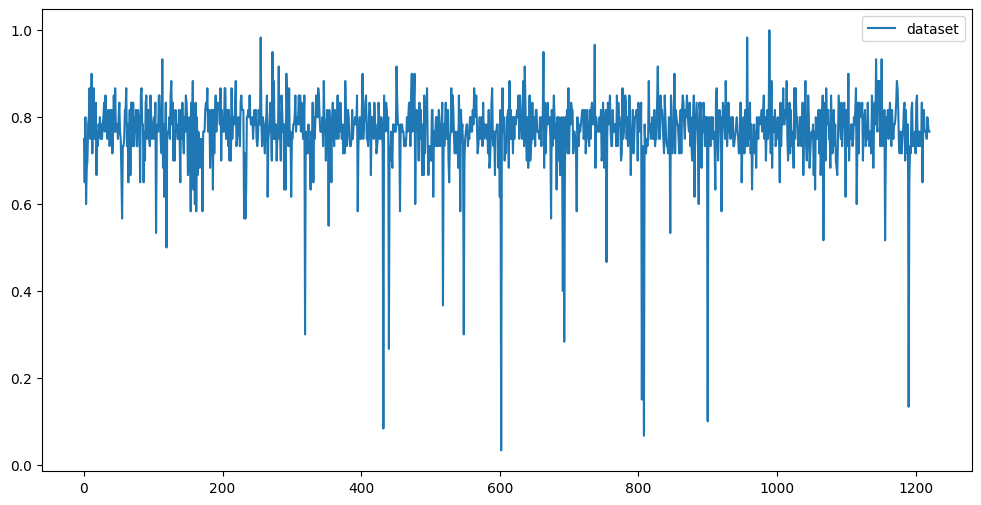

In [5]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('D:\Q-TV-RNN-Architecture\Q-TV-RNN\Q-data\speed_t4013_train.csv', usecols=[2], engine='python')
dataset = dataframe.values
stationary=verify_stationarity(dataset)
#dataframe=dataframe.diff(axis = 0, periods = 1)
#dataset = dataframe.dropna().values
dataset = dataset.astype('float32')
# normalize the dataset
print('dataset', dataset)
#dataset=dataset.dropna()
stationary = verify_stationarity(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
std=numpy.std(train)
# reshape into X=t and Y=t+1
look_back = period_size
tw = step_size
multi = look_back // tw
trainX, trainY, trainXU, trainYU, trainXL, trainYL = create_dataset(train, look_back, tw)
testX, testY , testXU, testYU, testXL, testYL= create_dataset(test, look_back, tw)
print(trainX)
plt.figure(figsize=(12, 6))
# plt.plot(ts, label="passengers")
plt.plot(train, label="dataset")
# plt.plot(anomalies_array, label="difference")
# plt.plot(newdata['ewa'], label="ewa")
plt.legend(loc='best')

#plt.show()
alpha=identify_alpha(dataset)
print('alpha',alpha)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainXU = numpy.reshape(trainXU, (trainXU.shape[0], trainXU.shape[1], 1))
testXU = numpy.reshape(testXU, (testXU.shape[0], testXU.shape[1], 1))

trainXL = numpy.reshape(trainXL, (trainXL.shape[0], trainXL.shape[1], 1))
testXL = numpy.reshape(testXL, (testXL.shape[0], testXL.shape[1], 1))
print(trainX)


In [6]:
print("Splitting datasets into 3 parts for ensemble training...")

# Split q50 (median) data
trainX_parts = numpy.array_split(trainX, 3)
trainY_parts = numpy.array_split(trainY, 3)

# Split q10 (lower) data
trainXL_parts = numpy.array_split(trainXL, 3)
trainYL_parts = numpy.array_split(trainYL, 3)

# Split q90 (upper) data
trainXU_parts = numpy.array_split(trainXU, 3)
trainYU_parts = numpy.array_split(trainYU, 3)



Splitting datasets into 3 parts for ensemble training...


In [7]:
print("Splitting test datasets into 3 parts for ensemble testing...")

# Split q50 (median) data
testX_parts = numpy.array_split(testX, 3)
testY_parts = numpy.array_split(testY, 3)

# Split q10 (lower) data
testXL_parts = numpy.array_split(testXL, 3)
testYL_parts = numpy.array_split(testYL, 3)

# Split q90 (upper) data
testXU_parts = numpy.array_split(testXU, 3)
testYU_parts = numpy.array_split(testYU, 3)

Splitting test datasets into 3 parts for ensemble testing...


In [8]:
trainX_parts[0].shape

(357, 3, 1)

In [9]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(multi)

(1070, 3, 1)
(1070,)
(373, 3, 1)
3


In [10]:

modelq50_1 = Sequential()
modelq50_1.add(SimpleRNN(4, input_shape=(multi, 1)) )
modelq50_1.add(Dense(1))
modelq50_1.add(Swish(beta=1.5))
modelq50_1.add(Activation(Swish(beta=1.5)))
modelq50_1.compile(loss=losses.logcosh, optimizer='adam')
modelq50_1.fit(trainX_parts[0], trainY_parts[0], epochs=50, batch_size=1, verbose=2)

modelq10_1 = Sequential()
modelq10_1.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq10_1.add(Dense(1))
modelq10_1.add(Swish(beta=1.5))
modelq10_1.add(Activation(Swish(beta=1.5)))
modelq10_1.compile(loss=losses.logcosh, optimizer='adam')
modelq10_1.fit(trainXL_parts[0], trainYL_parts[0], epochs=50, batch_size=1, verbose=2)

modelq90_1 = Sequential()
modelq90_1.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq90_1.add(Dense(1))
modelq90_1.add(Swish(beta=1.5))
modelq90_1.add(Activation(Swish(beta=1.5)))
modelq90_1.compile(loss=losses.logcosh, optimizer='adam')
modelq90_1.fit(trainXU_parts[0], trainYU_parts[0], epochs=50, batch_size=1, verbose=2)

beta 1.5
beta 1.5
Epoch 1/50


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000019FE6BFA870>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000019FE6BFA870>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000019FE6BFA870>>
beta 1.5 input <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000019FE6BFA870>>
357/357 - 2s - 5ms/step - loss: 0.0142
Epoch 2/50
357/357 - 0s - 1ms/step - loss: 0.0012
Epoch 3/50
357/357 - 0s - 1ms/step - loss: 3.7077e-04
Epoch 4/50
357/357 - 0s - 1ms/step - loss: 1.5464e-04
Epoch 5/50
357/357 - 0s - 1ms/step - loss: 7.4084e-05
Epoch 6/50
357/357 - 0s - 1ms/step - loss: 4.0533e-05
Epoch 7/50
357/357 - 0s - 1ms/step - loss: 2.6608e-05
Epoch 8/50
357/357 - 0s - 1ms/step - loss: 2.1237e-05
Epoch 9/50
357/357 - 0s - 1ms/step - loss: 1.9346e-05
Epoch 10/50
357/357 - 0s - 1ms/step - loss: 1.8751e-05
Epoch 11/50
357/357 - 

KeyboardInterrupt: 

In [ ]:

modelq50_2 = Sequential()
modelq50_2.add(SimpleRNN(4, input_shape=(multi, 1)) )
modelq50_2.add(Dense(1))
modelq50_2.add(Swish(beta=1.5))
modelq50_2.add(Activation(Swish(beta=1.5)))
modelq50_2.compile(loss=losses.logcosh, optimizer='adam')
modelq50_1.fit(trainX_parts[1], trainY_parts[1], epochs=50, batch_size=1, verbose=2)

modelq10_2 = Sequential()
modelq10_2.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq10_2.add(Dense(1))
modelq10_2.add(Swish(beta=1.5))
modelq10_2.add(Activation(Swish(beta=1.5)))
modelq10_2.compile(loss=losses.logcosh, optimizer='adam')
modelq10_1.fit(trainXL_parts[1], trainYL_parts[1], epochs=50, batch_size=1, verbose=2)

modelq90_2 = Sequential()
modelq90_2.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq90_2.add(Dense(1))
modelq90_2.add(Swish(beta=1.5))
modelq90_2.add(Activation(Swish(beta=1.5)))
modelq90_2.compile(loss=losses.logcosh, optimizer='adam')
modelq90_1.fit(trainXU_parts[1], trainYU_parts[1], epochs=50, batch_size=1, verbose=2)

In [ ]:

modelq50_3 = Sequential()
modelq50_3.add(SimpleRNN(4, input_shape=(multi, 1)) )
modelq50_3.add(Dense(1))
modelq50_3.add(Swish(beta=1.5))
modelq50_3.add(Activation(Swish(beta=1.5)))
modelq50_3.compile(loss=losses.logcosh, optimizer='adam')
modelq50_1.fit(trainX_parts[2], trainY_parts[2], epochs=50, batch_size=1, verbose=2)

modelq10_3 = Sequential()
modelq10_3.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq10_3.add(Dense(1))
modelq10_3.add(Swish(beta=1.5))
modelq10_3.add(Activation(Swish(beta=1.5)))
modelq10_3.compile(loss=losses.logcosh, optimizer='adam')
modelq10_1.fit(trainXL_parts[2], trainYL_parts[2], epochs=50, batch_size=1, verbose=2)

modelq90_3 = Sequential()
modelq90_3.add(SimpleRNN(4, input_shape=(multi, 1)))
modelq90_3.add(Dense(1))
modelq90_3.add(Swish(beta=1.5))
modelq90_3.add(Activation(Swish(beta=1.5)))
modelq90_3.compile(loss=losses.logcosh, optimizer='adam')
modelq90_1.fit(trainXU_parts[2], trainYU_parts[2], epochs=50, batch_size=1, verbose=2)

In [ ]:
# trainmeanPredict = modelmean.predict(trainX)
# testmeanPredict = modelmean.predict(testX)
# trainstdPredict = modelstd.predict(trainX)
# teststdPredict = modelstd.predict(testX)
# print('trainmeanPredict',trainmeanPredict)
i = 0
j = look_back
actual_quantile_interval = []
steps = tw
positive = True
anomalies=[]
finalres_q10 = []
finalres_q90 = []
dataframe = read_csv('D:\Q-TV-RNN-Architecture\Q-TV-RNN\Q-data\speed_t4013_labelled.csv', usecols=[2], engine='python')
dataset = dataframe.values
dataset = scaler.fit_transform(dataset)
ts = dataset
ts_accumulate=[]
comparison_dataset=[]
while j <= len(dataset):
    q50_array = []
    q10_array = []
    q90_array = []


    temp = dataset[i:j]
    actual_quantile_interval.append(
        numpy.absolute(numpy.quantile(dataset[i + 1:j + 1], lower_q_threshold) - numpy.quantile(dataset[i + 1:j + 1], median_q_threshold)))
    print('print here', temp)

    for m in range(0, len(temp), steps):
        q50array = []
        q10array = []
        q90array = []
        q50 = numpy.quantile(temp[m:m + steps], median_q_threshold)
        q50array.append(q50)
        q50_array.append(q50array)

        q90 = numpy.quantile(temp[m:m + steps], upper_q_threshold)
        q90array.append(q90)
        q90_array.append(q90array)

        q10 = numpy.quantile(temp[m:m + steps], lower_q_threshold)
        q10array.append(q10)
        q10_array.append(q10array)

    # print('stdarray1', std_array)
    # std_array = numpy.array(std_array)
    # print('stdarray2', std_array)
    # std_array = numpy.reshape(std_array, (std_array.shape[0],std_array.shape[1], 1))
    # print('stdarray3', std_array)
    # print('avg_array',avg_array)
    # avg_array = numpy.array(avg_array)
    # avg_array = numpy.reshape(avg_array, (avg_array.shape[0],1, 1))
    final_q50_array = []
    final_q50_array.append(q50_array)
    print('final_q10_array', final_q50_array)
    final_q10_array = []
    final_q10_array.append(q10_array)

    final_q90_array = []
    final_q90_array.append(q90_array)


    
    q50_predict = modelq50.predict(final_q50_array)
    print('q50_predict', q50_predict)
    q10_predict = modelq10.predict(final_q10_array)
    q90_predict = modelq90.predict(final_q90_array)

    if j+1 < len(dataset) :
        iqr=q90_predict-q10_predict
        ucl=q50_predict+.9*iqr
        lcl=q50_predict-.9*iqr
        diff=q50_predict-dataset[j+1]
        if dataset[j+1]>ucl or dataset[j+1]<lcl:
            anomalies.append(dataset[j+1])
        #print('data',dataset[j+1],'diff',diff)

        #comparison_dataset.append(dataset[j+1])
        #dataset=numpy.delete(dataset,j+1)
        #print('length',len(dataset))
    #finalres_q10.append(q10_predict)
    #finalres_q90.append(q90_predict)

    j = j + 1
    i = i + 1

# print('finalres',finalres)
'''prediction_array_q10 = []
prediction_array_q90 = []'''
anomalies_array=[]

for h in range(len(anomalies)):
    internal = anomalies[h]
    internal_array = []
    #internal_array.append(internal[0])
    anomalies_array.append(internal)
anomalies_array = scaler.inverse_transform(anomalies_array)
#comparison_dataset=scaler.inverse_transform(comparison_dataset)
#print(anomalies_array)
print('anomaly_iden', anomalies_array)
print('anomaly_iden size', len(anomalies_array))
'''for itr in range(len(anomalies_array)):
    print('data',comparison_dataset[itr],'diff',anomalies_array[itr])
print('anomaly length',len(anomalies_array))'''
'''ts_accumulate_another=[]
for h in range(len(finalres_q10)):
    internal = finalres_q10[h]
    internal_q90 = finalres_q90[h]
    prediction_array_q10.append(internal[0])
    prediction_array_q90.append(internal_q90[0])
for g in range(len(ts_accumulate)):
    internal=[]
    internal.append(ts_accumulate[g])
    #internal_q90 = finalres_q90[h]
    ts_accumulate_another.append(internal)
finalres_q10 = scaler.inverse_transform(prediction_array_q10)
finalres_q90 = scaler.inverse_transform(prediction_array_q90)
#print('finalres', finalres_q10)'''
'''trunc_finalres = []
for g in range(len(finalres)):
    trunc_finalres.append(finalres[g])'''
'''ts = ts[look_back:]
ts = scaler.inverse_transform(ts)
ts_accumulate=scaler.inverse_transform(ts_accumulate_another)
print('lenght', len(ts_accumulate), 'actual_quantile_interval', len(finalres_q10))'''
'''ts_array = []
for g in range(len(ts)):
    ts_array.append(ts[g])'''
'''finalres_q10_array=[]
finalres_q90_array=[]
for g in range(len(finalres_q10)-1):
    finalres_q10_array.append(finalres_q10[g])
    finalres_q90_array.append(finalres_q90[g])
prediction_errors = []'''
# for y in range(len(finalres_q10_array)):
#    print('ts_accumulate',ts_accumulate[y], 'finalres_q10_array', finalres_q10_array[y], 'finalres_q90_array', finalres_q90_array[y])
    #prediction_errors.append(numpy.absolute(actual_quantile_interval[y] - trunc_finalres[y]))
# testScore = math.sqrt(mean_squared_error(ts, trunc_finalres))
# print('Test Score: %.2f RMSE' % (testScore))
'''anomalies = identify_anomaly(anomalies_array)
print('anomaly_iden', anomalies)
print('anomaly_iden size', len(anomalies))
print(intersection(anomalies, anomaly_res))'''
plt.figure(figsize=(12, 6))
#plt.plot(ts, label="passengers")
plt.plot(dataset, label="dataset")
#plt.plot(anomalies_array, label="difference")
#plt.plot(newdata['ewa'], label="ewa")
plt.legend(loc='best')

plt.show()


anomaly_res =[15,11]
anomalies = numpy.unique(anomalies_array)
print('anomaly_iden', anomalies)
print('anomaly_iden size', len(anomalies))
print('ani', anomaly_res)
truep = (numpy.intersect1d(anomalies, numpy.array(anomaly_res)))
print("TP:")
tp = len(truep)
print(tp)
print("FP:")
fp = (len(anomalies) - len(truep))
print(fp)
print("FN:")
fn = len(anomaly_res) - len(truep)
print(fn)
print("TN:")
print(1670-tp-fp-fn)
#1670 - datapoints in yahoo8
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision:")
print(precision)
print("Recall:")
print(recall)

print here [[0.71212121]
 [0.78787879]
 [0.78787879]
 [0.8030303 ]
 [0.71212121]
 [0.78787879]
 [0.74242424]
 [0.74242424]
 [0.77272727]
 [0.77272727]
 [0.72727273]
 [0.81818182]
 [0.74242424]
 [0.78787879]
 [0.63636364]
 [0.77272727]
 [0.74242424]
 [0.74242424]
 [0.75757576]
 [0.75757576]
 [0.72727273]
 [0.78787879]
 [0.81818182]
 [0.72727273]
 [0.77272727]
 [0.71212121]
 [0.6969697 ]
 [0.8030303 ]
 [0.71212121]
 [0.77272727]
 [0.78787879]
 [0.77272727]
 [0.78787879]
 [0.83333333]
 [0.66666667]
 [0.72727273]
 [0.72727273]
 [0.72727273]
 [0.78787879]
 [0.74242424]
 [0.78787879]
 [0.71212121]
 [0.86363636]
 [0.78787879]
 [0.74242424]
 [0.77272727]
 [0.72727273]
 [0.81818182]
 [0.78787879]
 [0.81818182]
 [0.74242424]
 [0.78787879]
 [0.77272727]
 [0.78787879]
 [0.40909091]
 [0.40909091]
 [0.33333333]
 [0.72727273]
 [0.78787879]
 [0.86363636]
 [0.8030303 ]
 [0.81818182]
 [0.81818182]
 [0.75757576]
 [0.78787879]
 [0.83333333]
 [0.83333333]
 [0.74242424]
 [0.86363636]
 [0.78787879]
 [0.78787

<>:14: SyntaxWarning: invalid escape sequence '\Q'
<>:14: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9172\1875868813.py:14: SyntaxWarning: invalid escape sequence '\Q'
  dataframe = read_csv('D:\Q-TV-RNN-Architecture\Q-TV-RNN\Q-data\speed_t4013_labelled.csv', usecols=[2], engine='python')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9172\1875868813.py:14: SyntaxWarning: invalid escape sequence '\Q'
  dataframe = read_csv('D:\Q-TV-RNN-Architecture\Q-TV-RNN\Q-data\speed_t4013_labelled.csv', usecols=[2], engine='python')


IndexError: tuple index out of range